In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import tensorflow as tf
from tensorflow import keras
from skimage import transform
import os
import PIL

C:\Users\hashi\AppData\Local\Temp\ipykernel_28208\507206123.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


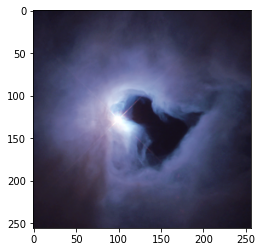

dimensions:
row: 256px col: 256px


In [2]:
# util functions for reading .tif/.png imgs

# takes a path for a .png format img and returns it as a np.ndarray
def read_img(path: str):
    try:
        img = plt.imread(path)
        return img
        
    except FileNotFoundError:
        print(f'unable to read path: {path} from the current directory')
        raise FileNotFoundError

# crop/resize .png format img to n x n x 3 img 
# default n = 256 so imgs are reformated to row: 256 col: 256 channels: 3 
def resize_img(img: np.ndarray, n: int=256):
    try:
        row, col, ch = img.shape

        scale = max(n / row, n / col)
        img = transform.rescale(img, scale, multichannel=True)
        return img[:n, :n, :]

    except:
        return f'unable to resize {*img.shape,} to 256, 256, 3'


# void function to graph a .png img to a matplotlib plot
def display_img(img: np.ndarray):
    plt.imshow(img)
    plt.show()

    row, col, ch = img.shape
    print(f'dimensions:\nrow: {row}px col: {col}px')

# example for reading and resizing a .png image from hubble_imgs and graphing it
img = read_img(r'./hubble_imgs_fixed/opo0010a.png')
img = resize_img(img)
display_img(img)


In [9]:
# UNPROCESSED DATA FROM KAGGLE: https://www.kaggle.com/datasets/redwankarimsony/top-100-hubble-telescope-images?resource=download
# had to delete some of the larger imgs from the dataset

# process training data from m,n,3 .tif imgs to 256,256,3 png imgs 
# commented out because i alr processed the data and deleted ./hubble_imgs 
# .tif img directory because it was taking up 4gbs of space
# for path in os.listdir(r'./hubble_imgs'):
#     read, write = os.path.join('hubble_imgs', path), os.path.join('hubble_imgs_fixed', path[:-4] + '.png')

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

C:\Users\hashi\AppData\Local\Temp\ipykernel_23288\4027885936.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


In [3]:
# reformating data into a csv *not really ideal the csv is very large so not really useable
# function which returns the csv header
def csv_header():
    repr = ''

    for row in range(256):
        for col in range(256):
            for channel in ('r', 'g', 'b', 'a'):
                repr += f'{row}x{col}{channel},'

    return repr[:-1]



# read data from directory *dirname into a formated processed csv
def imgs_to_csv(dirname: str, dest: str='hubble_data.csv'):
    try:
        # append each flattened img in hubble_img_fixed to hubble_imgs.csv file 
        with open(dest, 'ab') as csvstream:
            for img in os.listdir(dirname):
                img = read_img(os.path.join(dirname, img))
                # each channel *rgb has px values ranging from 0 to 1 as a floating pt num i.e x.xxxxxx
                np.savetxt(csvstream, img.reshape(1,262144), fmt='%1.6f', delimiter=',') 

    
    except FileNotFoundError:
        print(f'unable to find directory: {dirname}')

# imgs_to_csv('./hubble_imgs_fixed')
# img_df = pd.DataFrame(read_img('./hubble_imgs_fixed/opo0010a.png')[:, :, 0])
# print(img_df)
# print(csv_header())


0x0r,0x0g,0x0b,0x0a,0x1r,0x1g,0x1b,0x1a,0x2r,0x2g,0x2b,0x2a,0x3r,0x3g,0x3b,0x3a,0x4r,0x4g,0x4b,0x4a,0x5r,0x5g,0x5b,0x5a,0x6r,0x6g,0x6b,0x6a,0x7r,0x7g,0x7b,0x7a,0x8r,0x8g,0x8b,0x8a,0x9r,0x9g,0x9b,0x9a,0x10r,0x10g,0x10b,0x10a,0x11r,0x11g,0x11b,0x11a,0x12r,0x12g,0x12b,0x12a,0x13r,0x13g,0x13b,0x13a,0x14r,0x14g,0x14b,0x14a,0x15r,0x15g,0x15b,0x15a,0x16r,0x16g,0x16b,0x16a,0x17r,0x17g,0x17b,0x17a,0x18r,0x18g,0x18b,0x18a,0x19r,0x19g,0x19b,0x19a,0x20r,0x20g,0x20b,0x20a,0x21r,0x21g,0x21b,0x21a,0x22r,0x22g,0x22b,0x22a,0x23r,0x23g,0x23b,0x23a,0x24r,0x24g,0x24b,0x24a,0x25r,0x25g,0x25b,0x25a,0x26r,0x26g,0x26b,0x26a,0x27r,0x27g,0x27b,0x27a,0x28r,0x28g,0x28b,0x28a,0x29r,0x29g,0x29b,0x29a,0x30r,0x30g,0x30b,0x30a,0x31r,0x31g,0x31b,0x31a,0x32r,0x32g,0x32b,0x32a,0x33r,0x33g,0x33b,0x33a,0x34r,0x34g,0x34b,0x34a,0x35r,0x35g,0x35b,0x35a,0x36r,0x36g,0x36b,0x36a,0x37r,0x37g,0x37b,0x37a,0x38r,0x38g,0x38b,0x38a,0x39r,0x39g,0x39b,0x39a,0x40r,0x40g,0x40b,0x40a,0x41r,0x41g,0x41b,0x41a,0x42r,0x42g,0x42b,0x42a,0x43r,0x